In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
import random
random.seed(42)
random.shuffle(words)

In [5]:
block_size = 8

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> e
.......e ---> b
......eb ---> r
.....ebr ---> i
....ebri ---> m
...ebrim ---> a
..ebrima ---> .
........ ---> h
.......h ---> i
......hi ---> l
.....hil ---> t
....hilt ---> o
...hilto ---> n
..hilton ---> .
........ ---> j
.......j ---> h
......jh ---> e
.....jhe ---> n
....jhen ---> e
...jhene ---> .


In [12]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x):
        # calculate forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat  + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]


class FlattenConsecutive:

    def __init__(self, n):
        # n is the number of chars that we want to concat in the last dim of the output
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get all parameters of all layers
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42)

In [22]:
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [14]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  8, 15, 12],
        [ 0,  0,  1,  9, 19, 15, 19,  1],
        [ 0,  0,  0,  6,  5, 14, 20, 15],
        [ 0,  0,  0,  0,  0,  0,  0, 11]])

In [15]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [16]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [19]:
model.layers[0].out.shape # output of embedding layer (1st layer)
# output is {4, 8, 10]; every char-int gets replaced by its 10-dim vector representation

torch.Size([4, 8, 10])

In [20]:
model.layers[1].out.shape # output of flatten layer (2nd layer)
# output is [4, 80]; every example has its char vector representations flattened into a 1-D tensor

torch.Size([4, 80])

In [21]:
model.layers[2].out.shape # output of linear  layer (3rd layer)
# output is [4, 200]; just matrix multiplication with the weight matrix, we defined the next layer to have 200 neurons

torch.Size([4, 200])

In [22]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [26]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [30]:
e = torch.randn(4, 8, 10) # goal: turn this into (4, 4, 20) by grouping adjacent 10-d vectors
# e[:, ::2, :] # gets all the even-indexed character embeddings
# e[:, 1::2, :] # gets all the odd-indexed character embeddings
# explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
# ^this is cumbersome, let's just use .view()

In [31]:
e.view(4, 4, 20) == explicit

tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True]],

        [[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [T

In [23]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # X, Y batches

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2976
  10000/ 200000: 1.6812
  20000/ 200000: 2.2461
  30000/ 200000: 1.8141
  40000/ 200000: 1.8871
  50000/ 200000: 1.6353
  60000/ 200000: 1.7315
  70000/ 200000: 1.7281
  80000/ 200000: 1.7714
  90000/ 200000: 2.2859
 100000/ 200000: 1.9600
 110000/ 200000: 1.7778
 120000/ 200000: 1.2459
 130000/ 200000: 1.7583
 140000/ 200000: 1.7402
 150000/ 200000: 1.4548
 160000/ 200000: 2.1492
 170000/ 200000: 1.8308
 180000/ 200000: 1.4966
 190000/ 200000: 2.1324


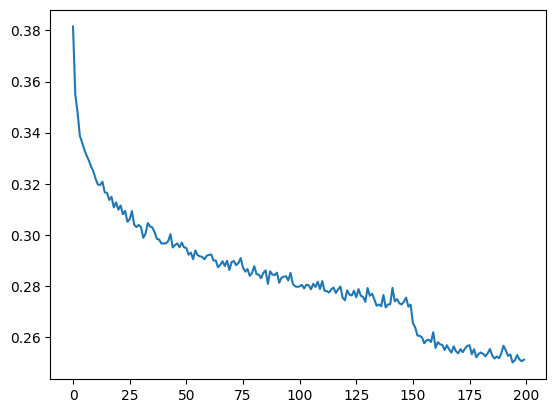

In [28]:
# to make the plot nicer, we can split the data into groups of say, 1000, and plot their means
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [29]:
# put all layers from training mode into eval mode
for layer in model.layers:
    layer.training = False

In [30]:
# evaluate loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7713382244110107
val 2.001082420349121


In [31]:
# sample from model

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        # forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample
        ix = torch.multinomial(probs, num_samples=1).item()
        out.append(ix)
        context = context[1:] + [ix]
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

brykai.
ameshamora.
karalyn.
brexlin.
anton.
ruquan.
evalyn.
itens.
gurneya.
noplovereth.
lilianah.
lily.
lizar.
blissa.
keena.
annenyi.
bridget.
memptati.
koi.
lillianna.
